In [1]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import integrate, signal, stats, fftpack
import pingouin as pg

## The following is needed to export text correctly for Illustrator ##
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)

In [4]:
%matplotlib notebook

Load Zap_Zip-log_exp to get metadata for experiments

In [5]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [6]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [7]:
area_colors = {
    'MO': (31/255, 157/255, 90/255), # [31, 157, 90] 'blue'
    'ACA': (64/255, 166/255, 102/255), # [64, 166, 102] 'deepskyblue'
    'SS': (24/255, 128/255, 100/255), # [24, 128, 100] 'blueviolet'
    'VIS': (8/255, 133/255, 140/255), # [8, 133, 140] 'green'
    'MO-TH': (255/255, 112/255, 128/255), # [255, 112, 128] 'steelblue'
#     'VIS-TH': 'olivedrab'
}

In [8]:
# state_colors = {
#     'awake': (120/255, 156/255, 74/255),
#     'anesthetized': (130/255, 122/255, 163/255),
#     'recovery': (93/255, 167/255, 229/255)
# }
state_colors = {
    'resting': 'royalblue',
    'running': 'seagreen',
    'anesthetized': 'indianred',
}

#### Functions

In [9]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

## Load subjects from file

In [10]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wPROBES.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [11]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_superficial

 575102
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation

MOs_deep

 546655
Experiment type: electrical and sensory stimulation
 551399
Experiment type: electrical stimulation
 551397
Experiment type: electrical and sensory stimulation
 569062
Experiment type: electrical and sensory stimulation
 569068
Experiment type: electrical and sensory stimulation
 569069
Experiment type: electrical and sensory stimulation
 569064
Experiment type: electrical and sensory stimulation
 569073
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation

SSp_superficial

 571620
Experiment type: electrical and sensory stimulation
 586466
Experiment type: electrical and sensory stimulation
 590479
Experiment type: electrical stimulation
 590480
Experiment type: electrical and sensory stimulation
 599017
Experiment type: electrical and sensory stimulation

SSp_deep

 569073
Experiment type: electr

In [12]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs'

## All subjects

In [13]:
## Parameters ##
sigalpha = 0.05 ## was 0.01

ctx_regions = ['MO', 'ACA', 'SS', 'VIS']
celltype = 'RS'
time_bin = 0.01 # size of time bins (s)

current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

response_window = {
    'early': [0.002, 0.025],
    'mid': [0.025, 0.15],
    'late': [0.15, 0.3],
}

In [15]:
all_subs_sig_units = []
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
        
        ## Load unit info ##
        fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
        if os.path.exists(fn_units_info):
            unit_info = pd.read_csv(fn_units_info)
            with open(os.path.join(evoked_data_folder, 'units_event_spikes.pkl'), 'rb') as unit_file:
                all_unit_event_spikes = pickle.load(unit_file)
        else:
            print('  {} not found. Not analyzing this subject.'.format(fn_units_stats))
            continue

        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        event_window = all_unit_event_spikes['event_window']
        bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
        timex = bins[:-1] + time_bin/2
        
        ## Load region LFP traces ONLY for regions with units AND LFP ##
        reg_unit_info = {}
        for region in ctx_regions:
            regdf = unit_info[(unit_info['cell_type'] == celltype) & (unit_info['parent'] == region)]
            if len(regdf) > 5: # was 8 for RS cells
                reg_unit_info[region] = regdf.sort_values(by='depth').reset_index(drop=True)
            else:
                print('  {}: n={:d} -> not enough units, excluding'.format(region, len(regdf)))
        if len(reg_unit_info) == 0:
            print('  Subject has no cortical regions to analyze.\n')
            continue
        
        ## Get event inds ##
        all_event_inds = {}
        for leveli, parami in zip(current_levels, currents_list):
            all_event_inds[leveli] = {}
            for statei in ['awake', 'anesthetized']:
                sweeps = mdata['states'][statei]
                if not sweeps:
                    continue
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                all_event_inds[leveli][statei] = np.concatenate(state_events)
                if statei == 'awake':
                    substates = ['resting', 'running']
                    for substatei in substates:
                        state_events = []
                        for sweepi in sweeps:
                            events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                            if len(events) == 0:
                                continue
                            state_events.append(events)
                        all_event_inds[leveli][substatei] = np.concatenate(state_events)
        
        print('  Getting modulated unit stats...')
        for leveli, states_events in all_event_inds.items():
            for statei, event_inds in states_events.items():
                regional_values = []
                for region in reg_unit_info.keys():
                    ## Get responsive units ##
                    for window, rwin in response_window.items():
                        all_unit_pvalues = np.zeros(len(reg_unit_info[region]), dtype=float)
                        all_unit_spcounts = np.zeros(len(reg_unit_info[region]), dtype=float)
                        for uni, uniti in enumerate(reg_unit_info[region]['unit_id'].values):
                            precount = np.zeros(len(event_inds), dtype=int)
                            postcount = np.zeros(len(event_inds), dtype=int)
                            for ii, evi in enumerate(event_inds):
                                event_spikes = all_unit_event_spikes['event_spikes'][uniti][evi]
                                precount[ii] = np.sum((event_spikes >= -rwin[1]) & (event_spikes <= -rwin[0]))
                                postcount[ii] = np.sum((event_spikes >= rwin[0]) & (event_spikes <= rwin[1]))
                            wstat, pval = stats.wilcoxon(x=postcount, y=precount, zero_method='zsplit')
                            spcount = np.mean(postcount) - np.mean(precount)
                            regional_values.append([uniti, region, window, spcount, pval])
                all_regions_df = pd.DataFrame(regional_values, columns=['unit_id', 'region', 'window', 'spikediff', 'pval'])
                for window in response_window.keys():
                    windowdf = all_regions_df[all_regions_df['window'] == window].copy()
                    rejects, windowdf['corrpval'] = pg.multicomp(windowdf['pval'].values, alpha=sigalpha, method='fdr_bh')
                    for region in reg_unit_info.keys():
                        stim_ctx = region == stim_area
                        regidf = windowdf[windowdf['region'] == region]
                        significant = regidf['corrpval'].values < sigalpha
                        excited = significant * (regidf['spikediff'].values > 0)
                        inhibited = significant * (regidf['spikediff'].values < 0)
                        
                        ## Store stats for each window ##
                        all_subs_sig_units.append([
                            group, mouse_num, stim_area, stim_depth, region, stim_ctx, len(reg_unit_info[region]),
                            leveli, statei, window, np.mean(excited), np.mean(inhibited), np.mean(significant)
                        ])
                del all_regions_df
        
        del unit_info, all_unit_event_spikes, stim_log, reg_unit_info
    print('')
## Create stats dataframe ##
all_subs_sig_df = pd.DataFrame(all_subs_sig_units, columns=[
    'group', 'mouse', 'stim_area', 'stim_depth', 'region', 'stim_cortex', 'num_units', 'stim_level', 'state', 'window',
    'excited', 'inhibited', 'significant'
])

MOs_superficial

 575102
  MO: n=3 -> not enough units, excluding
  SS: n=0 -> not enough units, excluding
  Getting modulated unit stats...
 571619
  SS: n=2 -> not enough units, excluding
  Getting modulated unit stats...

MOs_deep

 546655
  MO: n=0 -> not enough units, excluding
  ACA: n=0 -> not enough units, excluding
  SS: n=0 -> not enough units, excluding
  VIS: n=4 -> not enough units, excluding
  Subject has no cortical regions to analyze.

 551399
  ACA: n=4 -> not enough units, excluding
  VIS: n=0 -> not enough units, excluding
  Getting modulated unit stats...
 551397
  MO: n=5 -> not enough units, excluding
  VIS: n=0 -> not enough units, excluding
  Getting modulated unit stats...
 569062
  VIS: n=0 -> not enough units, excluding
  Getting modulated unit stats...
 569068
  ACA: n=0 -> not enough units, excluding
  VIS: n=0 -> not enough units, excluding
  Getting modulated unit stats...
 569069
  MO: n=3 -> not enough units, excluding
  ACA: n=3 -> not enough units, ex

In [16]:
subs_list = []
for index, row in all_subs_sig_df.iterrows():
    subs_list.append(row.mouse + '_' + row.group)
all_subs_sig_df['subject'] = subs_list
all_subs_sig_df.head()

,group,mouse,stim_area,stim_depth,region,stim_cortex,num_units,stim_level,state,window,excited,inhibited,significant,subject
0,MOs_superficial,575102,MO,superficial,ACA,False,6,low,awake,early,0.0,0.0,0.0,575102_MOs_superficial
1,MOs_superficial,575102,MO,superficial,VIS,False,12,low,awake,early,0.0,0.0,0.0,575102_MOs_superficial
2,MOs_superficial,575102,MO,superficial,ACA,False,6,low,awake,mid,0.0,0.0,0.0,575102_MOs_superficial
3,MOs_superficial,575102,MO,superficial,VIS,False,12,low,awake,mid,0.0,0.0,0.0,575102_MOs_superficial
4,MOs_superficial,575102,MO,superficial,ACA,False,6,low,awake,late,0.0,0.0,0.0,575102_MOs_superficial


In [17]:
print('Total subjects = {:d} mice'.format(len(np.unique(all_subs_sig_df['subject'].values))))
for depthi in ['superficial', 'deep']:
    depthdf = all_subs_sig_df[(all_subs_sig_df['stim_depth'] == depthi)]
    print(' {} stim: N={:d} mice'.format(depthi, len(np.unique(depthdf['subject'].values))))

Total subjects = 23 mice
 superficial stim: N=7 mice
 deep stim: N=16 mice


## Make figure 4 (was part of fig 3)

<IPython.core.display.Javascript object>


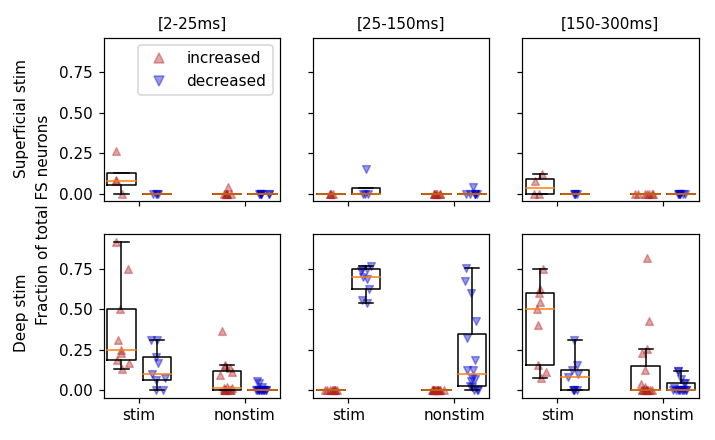

In [20]:
## This now averages across nonstim areas within each subject ##
plot_stim = 'medium'
plot_state = 'awake'
compare = ['superficial', 'deep']
ctx_stim = {'stim': [True, 'g', '*', 100], 'nonstim': [False, 'k', 'o', 50]}
# comp = {'excited': [(213/255, 94/255, 0/255), '^'], 'inhibited': [(0/255, 114/255, 178/255), 'v']}
comp = {'excited': ['firebrick', '^'], 'inhibited': ['mediumblue', 'v']}
locs1 = np.arange(len(ctx_stim) * (len(comp) + 1)).reshape((len(ctx_stim), (len(comp) + 1)))

fig, axs = plt.subplots(2, len(response_window), figsize=(6.5, 4), sharex=True, sharey=True)
fig.set_tight_layout({'rect': [0.06, 0, 1, 1], 'h_pad': 1.8, 'w_pad': 1.8})

for rowi, depthi in enumerate(compare):
    for ii, (stimlabel, stiminfo) in enumerate(ctx_stim.items()):
        for coli, windi in enumerate(response_window.keys()):
            dfb = all_subs_sig_df[
                (all_subs_sig_df['stim_depth'] == depthi) & (all_subs_sig_df['state'] == plot_state) &
                (all_subs_sig_df['stim_level'] == plot_stim) & (all_subs_sig_df['stim_cortex'] == stiminfo[0]) &
                (all_subs_sig_df['window'] == windi)
            ].groupby(['subject']).mean()
            for kk, (resp_type, rinfo) in enumerate(comp.items()):
                unit_fraction = dfb[resp_type].values
                xs = np.random.normal(locs1[ii,kk], 0.1, len(unit_fraction))
                axs[rowi, coli].boxplot(unit_fraction, positions=[locs1[ii,kk]], widths=[0.8], showfliers=False)
                axs[rowi, coli].scatter(xs, unit_fraction, color=rinfo[0], marker=rinfo[1], s=25, alpha=0.4)
            if (ii == 0) and (rowi == 0):
                axs[rowi, coli].set_title('[{:d}-{:d}ms]'.format(
                    int(response_window[windi][0]*1E3), int(response_window[windi][1]*1E3)))

# axs[rowi, coli].set_ylim([-0.05, 0.73])
axs[rowi, coli].set_xticks(np.mean(locs1[:,:-1], axis=1))
axs[rowi, coli].set_xticklabels(ctx_stim.keys())

fig.text(0.05, 0.5, 'Fraction of total {} neurons'.format(celltype), va='center', rotation='vertical')
fig.text(0.02, 0.73, 'Superficial stim', va='center', rotation='vertical')
fig.text(0.02, 0.29, 'Deep stim', va='center', rotation='vertical')

# Plot cut-off data point in fraction ##
# axs[1,0].scatter(0, 0.68, color=(213/255, 94/255, 0/255), marker='p', s=40, alpha=0.4)
# axs[1,0].scatter(0, 0.68, color='firebrick', marker='p', s=40, alpha=0.4)

## Add legends ##
FRhandles = []
for resp_type, rinfo in comp.items():
    FRhandles.append(Line2D([],[], color=rinfo[0], linestyle='none', marker=rinfo[1], markersize=6, alpha=0.4))
axs[0,0].legend(handles=FRhandles, labels=['increased', 'decreased'])

## Save ##
figname = 'Fig4_modunits_{}.png'.format(date.today().strftime('%b%d%Y'))
# figname = 'Fig4S1_modunits_{}_{}.png'.format(celltype, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

## Save as .pdf for Illustrator ##
# fig.savefig(os.path.join(plotsdir, 'AI_pdfs', figname.replace('.png', '.pdf')), transparent=True, dpi=300)

### Get the quantitative values

In [19]:
for depthi in ['superficial', 'deep']:
    print('{}'.format(depthi))
    for stimlabel, stiminfo in ctx_stim.items():
        stimdf = all_subs_sig_df[
            (all_subs_sig_df['stim_depth'] == depthi) & (all_subs_sig_df['state'] == plot_state) &
            (all_subs_sig_df['stim_level'] == plot_stim) & (all_subs_sig_df['stim_cortex'] == stiminfo[0])
        ]
        numsubs = len(np.unique(stimdf['subject'].values))
        numunits = np.sum(stimdf['num_units'].values)
        print('  {}: {:d} mice, n = {:d} units'.format(stimlabel, numsubs, numunits))
#         print(np.unique(stimdf['subjects'].values))

superficial
  stim: 4 mice, n = 180 units
  nonstim: 7 mice, n = 585 units
deep
  stim: 9 mice, n = 387 units
  nonstim: 16 mice, n = 1422 units


In [20]:
for windi in response_window.keys():
    print(windi)
    for depthi in ['superficial', 'deep']:
        print('{}'.format(depthi))
        for stimlabel, stiminfo in ctx_stim.items():
            stimdf = all_subs_sig_df[
                (all_subs_sig_df['stim_depth'] == depthi) & (all_subs_sig_df['state'] == plot_state) &
                (all_subs_sig_df['stim_level'] == plot_stim) & (all_subs_sig_df['stim_cortex'] == stiminfo[0]) &
                (all_subs_sig_df['window'] == windi)
            ].groupby(['subject']).mean()
            print(' {}'.format(stimlabel))
            for modi in ['excited', 'inhibited', 'significant']:
                print('  {}: median={:.2f} [{:.2f}-{:.2f}]'.format(
                    modi, np.median(stimdf[modi].values), np.percentile(stimdf[modi].values, 25),
                    np.percentile(stimdf[modi].values, 75)
                ))
        print('')
    print('')

early
superficial
 stim
  excited: median=0.05 [0.01-0.18]
  inhibited: median=0.00 [0.00-0.00]
  significant: median=0.05 [0.02-0.18]
 nonstim
  excited: median=0.00 [0.00-0.00]
  inhibited: median=0.00 [0.00-0.00]
  significant: median=0.00 [0.00-0.00]

deep
 stim
  excited: median=0.17 [0.11-0.23]
  inhibited: median=0.01 [0.00-0.04]
  significant: median=0.21 [0.15-0.23]
 nonstim
  excited: median=0.00 [0.00-0.01]
  inhibited: median=0.00 [0.00-0.00]
  significant: median=0.00 [0.00-0.02]


mid
superficial
 stim
  excited: median=0.00 [0.00-0.00]
  inhibited: median=0.00 [0.00-0.08]
  significant: median=0.00 [0.00-0.12]
 nonstim
  excited: median=0.00 [0.00-0.00]
  inhibited: median=0.00 [0.00-0.00]
  significant: median=0.00 [0.00-0.00]

deep
 stim
  excited: median=0.00 [0.00-0.00]
  inhibited: median=0.48 [0.40-0.59]
  significant: median=0.49 [0.40-0.59]
 nonstim
  excited: median=0.00 [0.00-0.01]
  inhibited: median=0.03 [0.02-0.25]
  significant: median=0.03 [0.02-0.27]


la

In [21]:
for windi in response_window.keys():
    print(windi)
    for stimlabel, stiminfo in ctx_stim.items():
        stimdf = all_subs_sig_df[
            (all_subs_sig_df['state'] == plot_state) & (all_subs_sig_df['stim_level'] == plot_stim) &
            (all_subs_sig_df['stim_cortex'] == stiminfo[0]) & (all_subs_sig_df['window'] == windi)
        ].groupby(['subject']).mean()
        print(' {}'.format(stimlabel))
        for modi in ['excited', 'inhibited', 'significant']:
            print('  {}: median={:.3f} [{:.3f}-{:.3f}]'.format(
                modi, np.median(stimdf[modi].values), np.percentile(stimdf[modi].values, 25),
                np.percentile(stimdf[modi].values, 75)
            ))
    print('')

early
 stim
  excited: median=0.156 [0.073-0.229]
  inhibited: median=0.000 [0.000-0.031]
  significant: median=0.190 [0.103-0.231]
 nonstim
  excited: median=0.000 [0.000-0.003]
  inhibited: median=0.000 [0.000-0.000]
  significant: median=0.000 [0.000-0.010]

mid
 stim
  excited: median=0.000 [0.000-0.000]
  inhibited: median=0.413 [0.181-0.525]
  significant: median=0.413 [0.222-0.543]
 nonstim
  excited: median=0.000 [0.000-0.009]
  inhibited: median=0.018 [0.000-0.109]
  significant: median=0.019 [0.000-0.126]

late
 stim
  excited: median=0.240 [0.118-0.283]
  inhibited: median=0.011 [0.000-0.059]
  significant: median=0.264 [0.132-0.334]
 nonstim
  excited: median=0.012 [0.000-0.046]
  inhibited: median=0.002 [0.000-0.026]
  significant: median=0.016 [0.000-0.072]



In [22]:
for windi in response_window.keys():
    print(windi)
    for depthi in ['superficial', 'deep']:
        print('{}'.format(depthi))
        for stimlabel, stiminfo in ctx_stim.items():
            stimdf = all_subs_sig_df[
                (all_subs_sig_df['stim_depth'] == depthi) & (all_subs_sig_df['state'] == plot_state) &
                (all_subs_sig_df['stim_level'] == plot_stim) & (all_subs_sig_df['stim_cortex'] == stiminfo[0]) &
                (all_subs_sig_df['window'] == windi)
            ].groupby(['subject']).mean()
            print(' {}'.format(stimlabel))
            for modi in ['excited', 'inhibited', 'significant']:
                print('  {}: mean={:.3f} [min {:.3f}, max {:.3f}]'.format(
                    modi, np.mean(stimdf[modi].values), np.min(stimdf[modi].values), np.max(stimdf[modi].values)
                ))
        print('')
    print('')

early
superficial
 stim
  excited: mean=0.108 [min 0.000, max 0.333]
  inhibited: mean=0.002 [min 0.000, max 0.012]
  significant: mean=0.110 [min 0.000, max 0.333]
 nonstim
  excited: mean=0.000 [min 0.000, max 0.000]
  inhibited: mean=0.000 [min 0.000, max 0.000]
  significant: mean=0.000 [min 0.000, max 0.000]

deep
 stim
  excited: mean=0.204 [min 0.000, max 0.833]
  inhibited: mean=0.025 [min 0.000, max 0.101]
  significant: mean=0.229 [min 0.034, max 0.833]
 nonstim
  excited: mean=0.006 [min 0.000, max 0.026]
  inhibited: mean=0.005 [min 0.000, max 0.033]
  significant: mean=0.012 [min 0.000, max 0.057]


mid
superficial
 stim
  excited: mean=0.019 [min 0.000, max 0.111]
  inhibited: mean=0.046 [min 0.000, max 0.167]
  significant: mean=0.065 [min 0.000, max 0.222]
 nonstim
  excited: mean=0.001 [min 0.000, max 0.008]
  inhibited: mean=0.002 [min 0.000, max 0.015]
  significant: mean=0.003 [min 0.000, max 0.015]

deep
 stim
  excited: mean=0.003 [min 0.000, max 0.025]
  inhibite

In [23]:
for windi in response_window.keys():
    print(windi)
    for stimlabel, stiminfo in ctx_stim.items():
        stimdf = all_subs_sig_df[
            (all_subs_sig_df['state'] == plot_state) & (all_subs_sig_df['stim_level'] == plot_stim) &
            (all_subs_sig_df['stim_cortex'] == stiminfo[0]) & (all_subs_sig_df['window'] == windi)
        ].groupby(['subject']).mean()
        print(' {}'.format(stimlabel))
        for modi in ['excited', 'inhibited', 'significant']:
            print('  {}: mean={:.3f} [min {:.3f}, max {:.3f}]'.format(
                modi, np.mean(stimdf[modi].values), np.min(stimdf[modi].values), np.max(stimdf[modi].values)
            ))
    print('')

early
 stim
  excited: mean=0.178 [min 0.000, max 0.833]
  inhibited: mean=0.018 [min 0.000, max 0.101]
  significant: mean=0.196 [min 0.000, max 0.833]
 nonstim
  excited: mean=0.005 [min 0.000, max 0.026]
  inhibited: mean=0.004 [min 0.000, max 0.033]
  significant: mean=0.008 [min 0.000, max 0.057]

mid
 stim
  excited: mean=0.007 [min 0.000, max 0.111]
  inhibited: mean=0.377 [min 0.000, max 0.750]
  significant: mean=0.385 [min 0.000, max 0.750]
 nonstim
  excited: mean=0.004 [min 0.000, max 0.020]
  inhibited: mean=0.101 [min 0.000, max 0.557]
  significant: mean=0.105 [min 0.000, max 0.557]

late
 stim
  excited: mean=0.194 [min 0.000, max 0.357]
  inhibited: mean=0.042 [min 0.000, max 0.241]
  significant: mean=0.237 [min 0.000, max 0.517]
 nonstim
  excited: mean=0.057 [min 0.000, max 0.372]
  inhibited: mean=0.020 [min 0.000, max 0.136]
  significant: mean=0.077 [min 0.000, max 0.441]



In [24]:
for windi in response_window.keys():
    print(windi)
    stimdf = all_subs_sig_df[
        (all_subs_sig_df['state'] == plot_state) & (all_subs_sig_df['stim_level'] == plot_stim) &
        (all_subs_sig_df['window'] == windi)
    ].groupby(['subject']).mean()
    for modi in ['excited', 'inhibited', 'significant']:
        print('  {}: mean={:.3f} [min {:.3f}, max {:.3f}]'.format(
            modi, np.mean(stimdf[modi].values), np.min(stimdf[modi].values), np.max(stimdf[modi].values)
        ))
    print('')

early
  excited: mean=0.055 [min 0.000, max 0.208]
  inhibited: mean=0.008 [min 0.000, max 0.048]
  significant: mean=0.063 [min 0.000, max 0.208]

mid
  excited: mean=0.004 [min 0.000, max 0.028]
  inhibited: mean=0.183 [min 0.000, max 0.613]
  significant: mean=0.188 [min 0.000, max 0.613]

late
  excited: mean=0.102 [min 0.000, max 0.343]
  inhibited: mean=0.027 [min 0.000, max 0.171]
  significant: mean=0.130 [min 0.000, max 0.461]



In [25]:
for windi in response_window.keys():
    print(windi)
    for stimlabel, stiminfo in ctx_stim.items():
        stimdf = all_subs_sig_df[
            (all_subs_sig_df['state'] == plot_state) & (all_subs_sig_df['stim_level'] == plot_stim) &
            (all_subs_sig_df['stim_cortex'] == stiminfo[0]) & (all_subs_sig_df['window'] == windi)
        ].groupby(['subject']).mean()
        print(' {}'.format(stimlabel))
        for modi in ['excited', 'inhibited', 'significant']:
            print('  {}: {:d} subs above FDR'.format(modi, np.sum(stimdf[modi].values > sigalpha)))
    print('')

early
 stim
  excited: 18 subs above FDR
  inhibited: 3 subs above FDR
  significant: 18 subs above FDR
 nonstim
  excited: 0 subs above FDR
  inhibited: 0 subs above FDR
  significant: 1 subs above FDR

mid
 stim
  excited: 1 subs above FDR
  inhibited: 18 subs above FDR
  significant: 18 subs above FDR
 nonstim
  excited: 0 subs above FDR
  inhibited: 7 subs above FDR
  significant: 7 subs above FDR

late
 stim
  excited: 17 subs above FDR
  inhibited: 8 subs above FDR
  significant: 17 subs above FDR
 nonstim
  excited: 6 subs above FDR
  inhibited: 4 subs above FDR
  significant: 7 subs above FDR



In [26]:
for windi in response_window.keys():
    print(windi)
    for depthi in ['superficial', 'deep']:
        print('{}'.format(depthi))
        for stimlabel, stiminfo in ctx_stim.items():
            stimdf = all_subs_sig_df[
                (all_subs_sig_df['stim_depth'] == depthi) & (all_subs_sig_df['state'] == plot_state) &
                (all_subs_sig_df['stim_level'] == plot_stim) & (all_subs_sig_df['stim_cortex'] == stiminfo[0]) &
                (all_subs_sig_df['window'] == windi)
            ].groupby(['subject']).mean()
            print(' {}'.format(stimlabel))
            for modi in ['excited', 'inhibited', 'significant']:
                print('  {}: {:d}/{:d} subs above FDR'.format(
                    modi, np.sum(stimdf[modi].values > sigalpha), len(stimdf)))
        print('')
    print('')

early
superficial
 stim
  excited: 3/6 subs above FDR
  inhibited: 0/6 subs above FDR
  significant: 3/6 subs above FDR
 nonstim
  excited: 0/7 subs above FDR
  inhibited: 0/7 subs above FDR
  significant: 0/7 subs above FDR

deep
 stim
  excited: 15/16 subs above FDR
  inhibited: 3/16 subs above FDR
  significant: 15/16 subs above FDR
 nonstim
  excited: 0/16 subs above FDR
  inhibited: 0/16 subs above FDR
  significant: 1/16 subs above FDR


mid
superficial
 stim
  excited: 1/6 subs above FDR
  inhibited: 2/6 subs above FDR
  significant: 2/6 subs above FDR
 nonstim
  excited: 0/7 subs above FDR
  inhibited: 0/7 subs above FDR
  significant: 0/7 subs above FDR

deep
 stim
  excited: 0/16 subs above FDR
  inhibited: 16/16 subs above FDR
  significant: 16/16 subs above FDR
 nonstim
  excited: 0/16 subs above FDR
  inhibited: 7/16 subs above FDR
  significant: 7/16 subs above FDR


late
superficial
 stim
  excited: 1/6 subs above FDR
  inhibited: 0/6 subs above FDR
  significant: 1/6 su

In [64]:
stimdf.groupby('subject').max()

,stim_cortex,num_units,excited,inhibited,significant
subject,,,,,
551397_MOs_deep,0.0,86.000000,0.004425,0.025424,0.029849
551399_MOs_deep,0.0,55.000000,0.087719,0.021053,0.108772
569062_MOs_deep,0.0,153.000000,0.005747,0.000000,0.005747
569064_MOs_deep,0.0,47.500000,0.010000,0.010000,0.020000
569068_MOs_deep,0.0,66.000000,0.000000,0.015152,0.015152
569069_MOs_deep,0.0,50.000000,0.158537,0.086399,0.244936
569072_SSp_deep,0.0,118.000000,0.030976,0.004854,0.035831
569073_MOs_deep,0.0,40.333333,0.000000,0.000000,0.000000
569073_SSp_deep,0.0,54.333333,0.014815,0.000000,0.014815


Plot ratio of modulated cells

<IPython.core.display.Javascript object>


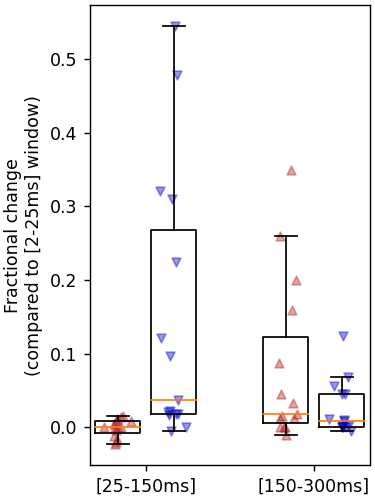

In [42]:
plot_stim = 'medium'
plot_state = 'awake'
depthi = 'deep'
stimctx = False
comp_windows = ['mid', 'late']
locs2 = np.arange(len(comp_windows) * (len(comp) + 1)).reshape((len(comp_windows), (len(comp) + 1)))

dfearly = all_subs_sig_df[
    (all_subs_sig_df['stim_depth'] == depthi) & (all_subs_sig_df['state'] == plot_state) &
    (all_subs_sig_df['stim_level'] == plot_stim) & (all_subs_sig_df['stim_cortex'] == stimctx) &
    (all_subs_sig_df['window'] == 'early')
].groupby(['subject']).mean()

fig, ax = plt.subplots(figsize=(3,4), constrained_layout=True)
for ii, windi in enumerate(comp_windows):
    dfb = all_subs_sig_df[
        (all_subs_sig_df['stim_depth'] == depthi) & (all_subs_sig_df['state'] == plot_state) &
        (all_subs_sig_df['stim_level'] == plot_stim) & (all_subs_sig_df['stim_cortex'] == stimctx) &
        (all_subs_sig_df['window'] == windi)
    ].groupby(['subject']).mean()
    for kk, (resp_type, rinfo) in enumerate(comp.items()):
        deltaFR = dfb[resp_type].values - dfearly[resp_type].values
        xs = np.random.normal(locs2[ii,kk], 0.1, len(deltaFR))
        ax.boxplot(deltaFR, positions=[locs2[ii,kk]], widths=[0.8], showfliers=False)
        ax.scatter(xs, deltaFR, color=rinfo[0], marker=rinfo[1], s=25, alpha=0.4)
ax.set_xticks(np.mean(locs2[:,:-1], axis=1))
ax.set_xticklabels(['[25-150ms]', '[150-300ms]'])
ax.set_ylabel('Fractional change\n(compared to [2-25ms] window)')

## Save ##
figname = 'Fig4g_delta_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

Plot significantly increased/decreased cells separately

<IPython.core.display.Javascript object>


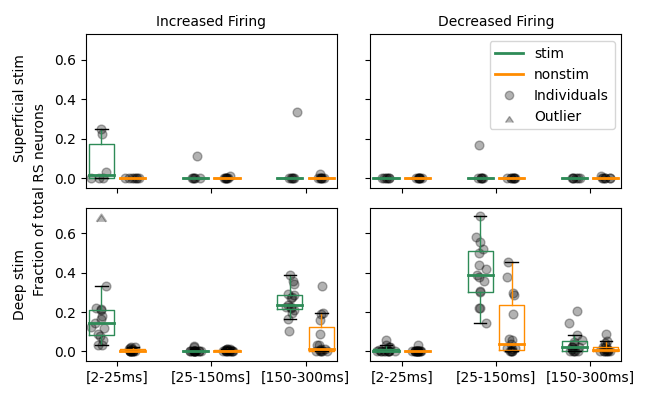

In [68]:
## This now averages across nonstim areas within each subject ##
plot_stim = 'medium'
plot_state = 'resting'
compare = ['superficial', 'deep']
ctx_stim = {'stim': [True, 'seagreen', 'o', 100], 'nonstim': [False, 'darkorange', 'o', 50]}
comp = ['excited', 'inhibited']
locs2 = np.arange(len(response_window) * (len(ctx_stim) + 1)).reshape((len(response_window), (len(ctx_stim) + 1)))

fig, axs = plt.subplots(2, 2, figsize=(6.5, 4), sharex=True, sharey=True)
fig.set_tight_layout({'rect': [0.06, 0, 1, 1]})#, 'pad': 1.0, 'w_pad': 0.5})

for rowi, depthi in enumerate(compare):
    for ii, windi in enumerate(response_window.keys()):
        for jj, (stimlabel, stiminfo) in enumerate(ctx_stim.items()):
            dfb = all_subs_sig_df[
                (all_subs_sig_df['stim_depth'] == depthi) & (all_subs_sig_df['state'] == plot_state) &
                (all_subs_sig_df['stim_level'] == plot_stim) & (all_subs_sig_df['stim_cortex'] == stiminfo[0]) &
                (all_subs_sig_df['window'] == windi)
            ].groupby(['subject']).mean()
            for coli, resp_type in enumerate(comp):
                unit_fraction = dfb[resp_type].values
                xs = np.random.normal(locs2[ii,jj], 0.1, len(unit_fraction))
                boxwh = axs[rowi, coli].boxplot(
                    unit_fraction, positions=[locs2[ii,jj]], widths=[0.8], showfliers=False,
                    medianprops={'color': stiminfo[1], 'linewidth': 2},
                    boxprops={'color': stiminfo[1]}, whiskerprops={'color': stiminfo[1]}
                )
                
                axs[rowi, coli].scatter(xs, unit_fraction, c='k', marker=stiminfo[2], s=40, alpha=0.3)
                
                
#             if (ii == 0) and (rowi == 0):
#                 axs[rowi, coli].set_title('[{:d}-{:d}ms]'.format(
#                     int(response_window[windi][0]*1E3), int(response_window[windi][1]*1E3)))

axs[0,0].set_title('Increased Firing')
axs[0,1].set_title('Decreased Firing')
axs[rowi, coli].set_ylim([-0.05, 0.73])
axs[rowi, coli].set_xticks(np.mean(locs2[:,:-1], axis=1))
# axs[rowi, coli].set_xticklabels(response_window.keys())
axs[rowi, coli].set_xticklabels(['[2-25ms]', '[25-150ms]', '[150-300ms]'])

fig.text(0.05, 0.5, 'Fraction of total RS neurons', va='center', rotation='vertical')
fig.text(0.02, 0.73, 'Superficial stim', va='center', rotation='vertical')
fig.text(0.02, 0.29, 'Deep stim', va='center', rotation='vertical')

# Plot cut-off data point in fraction ##
axs[1,0].scatter(0, 0.7, c='k', marker=6, s=50, alpha=0.3)

## Add legends ##
leghandles = [
    Line2D([0], [0], c='seagreen', linewidth=2, label='stim'),
    Line2D([0], [0], c='darkorange', linewidth=2, label='nonstim'),
    Line2D([0], [0], linestyle='none', c='k', marker='o', alpha=0.3, label='Individuals'),
    Line2D([0], [0], linestyle='none', c='k', marker=6, alpha=0.3, label='Outlier')
]
axs[0,1].legend(handles=leghandles)

## Save ##
figname = 'Fig4_splitmod_v6_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)